In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import extract 

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500.]),
 <a list of 7 Text xticklabel objects>)

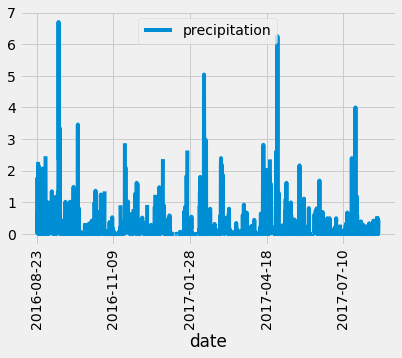

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
#Starting from the last data point in the database. 


# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = []
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date','precipitation'])
df.set_index(df['date'], inplace=True)

# Sort the dataframe by date
df = df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.xticks(rotation='vertical')

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# How many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [13]:
# What are the most active stations?
session.query(Measurement.station, func.count(Measurement.station)).all()
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station 'USC00519281'?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

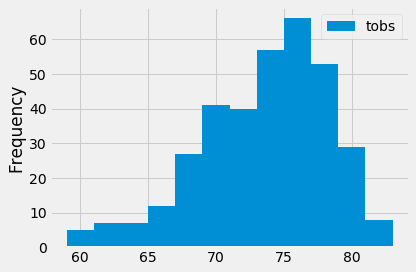

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= prev_year).all()
df = pd.DataFrame(results, columns=['tobs'])

df.plot.hist(bins=12)
plt.tight_layout()

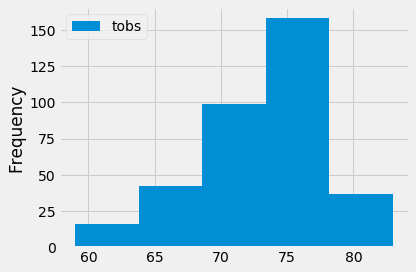

In [16]:
# skill drill - 5 bins
df.plot.hist(bins=5)
plt.tight_layout()

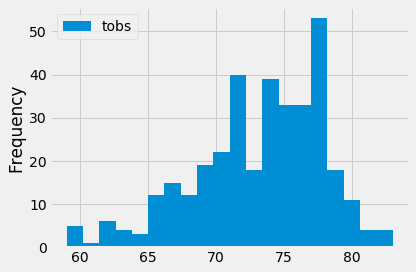

In [17]:
# skill drill - 20 bins
df.plot.hist(bins=20)
plt.tight_layout()

In [65]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start=None, end=None):
    sel = [func.min(Measurement.tobs), func.avg(
             Measurement.tobs), func.max(Measurement.tobs)]
    if not end:
        results = session.query(*sel).\
                   filter(Measurement.date >= start).\
                   filter(Measurement.date <= end).all()
        temps = list(np.ravel(results))
        return temps

    results = session.query(*sel).\
      filter(Measurement.date >= start).\
      filter(Measurement.date <= end).all()
    temps = list(np.ravel(results))
    return temps

calc_temps("2015-06-01","2015-06-30")


[66.0, 74.99014778325123, 81.0]

# Challenge

In [99]:
### getting weather (temperature and precipitation) key statistics for the months of June and December across all stations

In [105]:
# for information, get the date range of the data
date_min = session.query(func.min(Measurement.date)).all()
date_max = session.query(func.max(Measurement.date)).all()
print(date_min)
print(date_max)

[('2010-01-01',)]
[('2017-08-23',)]


In [100]:
# temperature key statistics for June
# using the "extract" method from sqlalchemy - "from sqlalchemy import extract" added with dependencies
tobs_june = session.query(Measurement.date, Measurement.tobs).filter(extract('month',Measurement.date)==6).all()
tobs_june_df=pd.DataFrame(tobs_june)
tobs_june_df.describe()

,tobs
count,1700.000000
mean,74.944118
std,3.257417
min,64.000000
25%,73.000000
50%,75.000000
75%,77.000000
max,85.000000


In [101]:
# temperature key statistics for December
tobs_dec = session.query(Measurement.date, Measurement.tobs).filter(extract('month',Measurement.date)==12).all()
tobs_dec_df=pd.DataFrame(tobs_dec)
tobs_dec_df.describe()

,tobs
count,1517.000000
mean,71.041529
std,3.745920
min,56.000000
25%,69.000000
50%,71.000000
75%,74.000000
max,83.000000


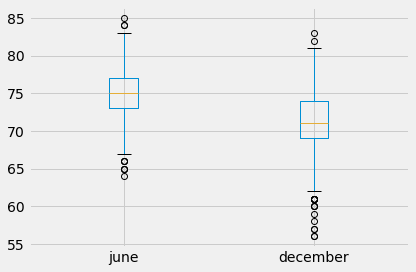

In [102]:
# create a temperature box-and-whisker of each month
column_names = ["june", "december"]
tobs_df=pd.DataFrame(columns=column_names)
tobs_df["june"]= tobs_june_df["tobs"]
tobs_df["december"]=tobs_dec_df["tobs"]

tobs_df.boxplot(column=["june", "december"])
plt.tight_layout()

In [106]:
## steady temperature, as expected with few outliers (which may happen at nighttime)

In [107]:
# precipitation key statistics for June
prcp_june = session.query(Measurement.date, Measurement.prcp).filter(extract('month',Measurement.date)==6).all()
prcp_june_df=pd.DataFrame(prcp_june)
prcp_june_df.describe()

,prcp
count,1574.000000
mean,0.136360
std,0.335731
min,0.000000
25%,0.000000
50%,0.020000
75%,0.120000
max,4.430000


In [108]:
# precipitation key statistics for December
prcp_dec = session.query(Measurement.date, Measurement.prcp).filter(extract('month',Measurement.date)==12).all()
prcp_dec_df=pd.DataFrame(prcp_dec)
prcp_dec_df.describe()

,prcp
count,1405.000000
mean,0.216819
std,0.541399
min,0.000000
25%,0.000000
50%,0.030000
75%,0.150000
max,6.420000


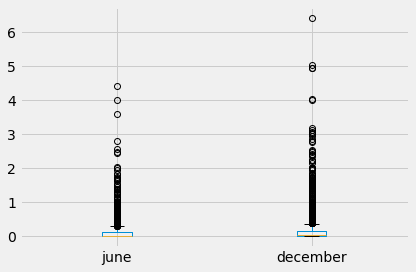

In [109]:
# create a precipitation box-and-whisker of each month
column_names = ["june", "december"]
prcp_df=pd.DataFrame(columns=column_names)
prcp_df["june"]= prcp_june_df["prcp"]
prcp_df["december"]=prcp_dec_df["prcp"]

prcp_df.boxplot(column=["june", "december"])
plt.tight_layout()

In [ ]:
# most key statistics low as expected, but there are a lot of outliers that could be investigated
# get key statistics for each station and compare and compare number of outliers
# get key statistics on outliers regarding timestamp (if possible) to understand if there's a pattern in the month/day/night
# and if they tend to be close to each other in time (whoch could mean full day(s) of rain)

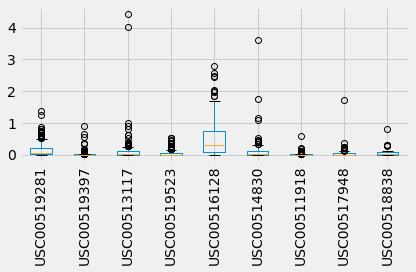

In [96]:
# we can already get the key statistics per month and per station
# comparing each station's precipitaion June key statistics in a box-and-whisker plot
prcp_june_USC00519281 = session.query(Measurement.date, Measurement.prcp).filter(extract('month',Measurement.date)==6)\
                                .filter(Measurement.station == 'USC00519281').all()
prcp_june_USC00519281_df=pd.DataFrame(prcp_june_USC00519281)
prcp_june_USC00519397 = session.query(Measurement.date, Measurement.prcp).filter(extract('month',Measurement.date)==6)\
                                .filter(Measurement.station == 'USC00519397').all()
prcp_june_USC00519397_df=pd.DataFrame(prcp_june_USC00519397)
prcp_june_USC00513117 = session.query(Measurement.date, Measurement.prcp).filter(extract('month',Measurement.date)==6)\
                                .filter(Measurement.station == 'USC00513117').all()
prcp_june_USC00513117_df=pd.DataFrame(prcp_june_USC00513117)
prcp_june_USC00519523 = session.query(Measurement.date, Measurement.prcp).filter(extract('month',Measurement.date)==6)\
                                .filter(Measurement.station == 'USC00519523').all()
prcp_june_USC00519523_df=pd.DataFrame(prcp_june_USC00519523)
prcp_june_USC00516128 = session.query(Measurement.date, Measurement.prcp).filter(extract('month',Measurement.date)==6)\
                                .filter(Measurement.station == 'USC00516128').all()
prcp_june_USC00516128_df=pd.DataFrame(prcp_june_USC00516128)
prcp_june_USC00514830 = session.query(Measurement.date, Measurement.prcp).filter(extract('month',Measurement.date)==6)\
                                .filter(Measurement.station == 'USC00514830').all()
prcp_june_USC00514830_df=pd.DataFrame(prcp_june_USC00514830)
prcp_june_USC00511918 = session.query(Measurement.date, Measurement.prcp).filter(extract('month',Measurement.date)==6)\
                                .filter(Measurement.station == 'USC00511918').all()
prcp_june_USC00511918_df=pd.DataFrame(prcp_june_USC00511918)
prcp_june_USC00517948 = session.query(Measurement.date, Measurement.prcp).filter(extract('month',Measurement.date)==6)\
                                .filter(Measurement.station == 'USC00517948').all()
prcp_june_USC00517948_df=pd.DataFrame(prcp_june_USC00517948)
prcp_june_USC00518838 = session.query(Measurement.date, Measurement.prcp).filter(extract('month',Measurement.date)==6)\
                                .filter(Measurement.station == 'USC00518838').all()
prcp_june_USC00518838_df=pd.DataFrame(prcp_june_USC00518838)

column_names = ["USC00519281", "USC00519397", "USC00513117", "USC00519523", "USC00516128", "USC00514830", "USC00511918", "USC00517948", "USC00518838"]
prcp_june_stations=pd.DataFrame(columns=column_names)
prcp_june_stations["USC00519281"]= prcp_june_USC00519281_df["prcp"]
prcp_june_stations["USC00519397"]= prcp_june_USC00519397_df["prcp"]
prcp_june_stations["USC00513117"]= prcp_june_USC00513117_df["prcp"]
prcp_june_stations["USC00519523"]= prcp_june_USC00519523_df["prcp"]
prcp_june_stations["USC00516128"]= prcp_june_USC00516128_df["prcp"]
prcp_june_stations["USC00514830"]= prcp_june_USC00514830_df["prcp"]
prcp_june_stations["USC00511918"]= prcp_june_USC00511918_df["prcp"]
prcp_june_stations["USC00517948"]= prcp_june_USC00517948_df["prcp"]
prcp_june_stations["USC00518838"]= prcp_june_USC00518838_df["prcp"]


prcp_june_stations.boxplot(column=["USC00519281", "USC00519397", "USC00513117", "USC00519523", "USC00516128", "USC00514830", "USC00511918", "USC00517948", "USC00518838"])
plt.xticks(rotation='vertical')
plt.tight_layout()

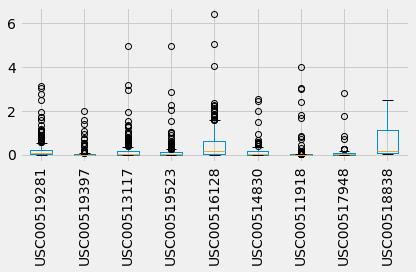

In [97]:
# comparing each station's precipitaion December key statistics in a box-and-whisker plot
prcp_dec_USC00519281 = session.query(Measurement.date, Measurement.prcp).filter(extract('month',Measurement.date)==12)\
                                .filter(Measurement.station == 'USC00519281').all()
prcp_dec_USC00519281_df=pd.DataFrame(prcp_dec_USC00519281)
prcp_dec_USC00519397 = session.query(Measurement.date, Measurement.prcp).filter(extract('month',Measurement.date)==12)\
                                .filter(Measurement.station == 'USC00519397').all()
prcp_dec_USC00519397_df=pd.DataFrame(prcp_dec_USC00519397)
prcp_dec_USC00513117 = session.query(Measurement.date, Measurement.prcp).filter(extract('month',Measurement.date)==12)\
                                .filter(Measurement.station == 'USC00513117').all()
prcp_dec_USC00513117_df=pd.DataFrame(prcp_dec_USC00513117)
prcp_dec_USC00519523 = session.query(Measurement.date, Measurement.prcp).filter(extract('month',Measurement.date)==12)\
                                .filter(Measurement.station == 'USC00519523').all()
prcp_dec_USC00519523_df=pd.DataFrame(prcp_dec_USC00519523)
prcp_dec_USC00516128 = session.query(Measurement.date, Measurement.prcp).filter(extract('month',Measurement.date)==12)\
                                .filter(Measurement.station == 'USC00516128').all()
prcp_dec_USC00516128_df=pd.DataFrame(prcp_dec_USC00516128)
prcp_dec_USC00514830 = session.query(Measurement.date, Measurement.prcp).filter(extract('month',Measurement.date)==12)\
                                .filter(Measurement.station == 'USC00514830').all()
prcp_dec_USC00514830_df=pd.DataFrame(prcp_dec_USC00514830)
prcp_dec_USC00511918 = session.query(Measurement.date, Measurement.prcp).filter(extract('month',Measurement.date)==12)\
                                .filter(Measurement.station == 'USC00511918').all()
prcp_dec_USC00511918_df=pd.DataFrame(prcp_dec_USC00511918)
prcp_dec_USC00517948 = session.query(Measurement.date, Measurement.prcp).filter(extract('month',Measurement.date)==12)\
                                .filter(Measurement.station == 'USC00517948').all()
prcp_dec_USC00517948_df=pd.DataFrame(prcp_dec_USC00517948)
prcp_dec_USC00518838 = session.query(Measurement.date, Measurement.prcp).filter(extract('month',Measurement.date)==12)\
                                .filter(Measurement.station == 'USC00518838').all()
prcp_dec_USC00518838_df=pd.DataFrame(prcp_dec_USC00518838)

column_names = ["USC00519281", "USC00519397", "USC00513117", "USC00519523", "USC00516128", "USC00514830", "USC00511918", "USC00517948", "USC00518838"]
prcp_dec_stations=pd.DataFrame(columns=column_names)
prcp_dec_stations["USC00519281"]= prcp_dec_USC00519281_df["prcp"]
prcp_dec_stations["USC00519397"]= prcp_dec_USC00519397_df["prcp"]
prcp_dec_stations["USC00513117"]= prcp_dec_USC00513117_df["prcp"]
prcp_dec_stations["USC00519523"]= prcp_dec_USC00519523_df["prcp"]
prcp_dec_stations["USC00516128"]= prcp_dec_USC00516128_df["prcp"]
prcp_dec_stations["USC00514830"]= prcp_dec_USC00514830_df["prcp"]
prcp_dec_stations["USC00511918"]= prcp_dec_USC00511918_df["prcp"]
prcp_dec_stations["USC00517948"]= prcp_dec_USC00517948_df["prcp"]
prcp_dec_stations["USC00518838"]= prcp_dec_USC00518838_df["prcp"]


prcp_dec_stations.boxplot(column=["USC00519281", "USC00519397", "USC00513117", "USC00519523", "USC00516128", "USC00514830", "USC00511918", "USC00517948", "USC00518838"])
plt.xticks(rotation='vertical')
plt.tight_layout()